In [1]:
# Importing the necessary modules 
import os
import pandas as pd
from textblob import TextBlob
import pyspark.pandas as ps
from pyspark.sql.functions import pandas_udf, col, udf,expr, from_json
from pyspark.sql.types import FloatType, StringType, StructType
from pyspark.sql import SparkSession
from kafka import KafkaConsumer, KafkaProducer
import findspark
import json

In [2]:
# Declaring the spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Twitter Sentiment") \
    .getOrCreate()

22/10/16 13:43:32 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# Subscribing to the kafka topic that receives the data and read from it
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", "kafka_tweets_stream") \
    .option("startingOffsets", "earliest") \
    .load()

In [4]:
# UDF that classifies the tweets as a positive/negative/neutral sentiment
# Binary classification 
@udf(returnType=StringType())
def sentiment_fxn(text: str):
    try:
        sent_cal = round(float(TextBlob(text).sentiment.polarity), 2)
        if sent_cal > 0:
            return "Postive"
        elif sent_cal < 0:
            return "Negative"
        return "Neutral"
    except:
        return None

In [5]:
# The schema of the streamed data has the expected data represented by the 'value' key
# Using the SQL select statement to cast the binary data as string
my_df = df.selectExpr("CAST(value as STRING)")

In [6]:
# Expected schema of the expected data
sample_schema = (
    StructType()
    .add("created_at", StringType())
    .add("id", StringType())
    .add("id_str" , StringType())
    .add("text", StringType())
    .add("source", StringType())
    .add("truncated", StringType())
    .add("in_reply_to_status_id", StringType())
    .add("in_reply_to_status_id_str", StringType())
    .add("in_reply_to_user_id", StringType())
    .add("in_reply_to_user_id_str", StringType())
    .add("in_reply_to_screen_name", StringType())
    .add("user", StringType())
    .add("geo", StringType())
    .add("coordinates", StringType())
    .add("place", StringType())
    .add("contributors", StringType())
    .add("retweeted_status", StringType())
    .add("is_quote_status", StringType())
    .add("quote_count", StringType())
    .add("reply_count", StringType())
    .add("retweet_count", StringType())
    .add("favorite_count", StringType())
    .add("entities", StringType())
    .add("favorited", StringType())
    .add("retweeted", StringType())
    .add("possibly_sensitive", StringType())
    .add("filter_level", StringType())
    .add("lang", StringType())
    .add("timestamp_ms", StringType())
)

In [7]:
# Use the schema above to apply on the data
into_dataframe = my_df.select(
        from_json(col("value"), sample_schema).alias("sample")
    )

22/10/16 13:45:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
# Get the data into a dataframe
into_df = into_dataframe.select("sample.*")

In [9]:
# Run the classification function on the text column of the dataframe
sent_df = into_df.withColumn("sentiment", sentiment_fxn(col('text')))

In [11]:
# Run an aggregate query on the df to enable wrtieStream
aggDF = sent_df.groupBy('sentiment').count()

In [ ]:
# Writing the aggregated data to memory as a table so we can perform SQL operations on it
aggDF.writeStream \
    .queryName("aggregates") \
    .outputMode("complete") \
    .format("memory") \
    .start()

In [60]:
# Selecting all and converting to pandas df to enable plotting
final_result = spark.sql("select * from aggregates").toPandas()

In [ ]:
# Display the aggregated table
final_result

22/10/16 16:31:36 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894


22/10/16 16:31:44 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894


<AxesSubplot: xlabel='sentiment'>

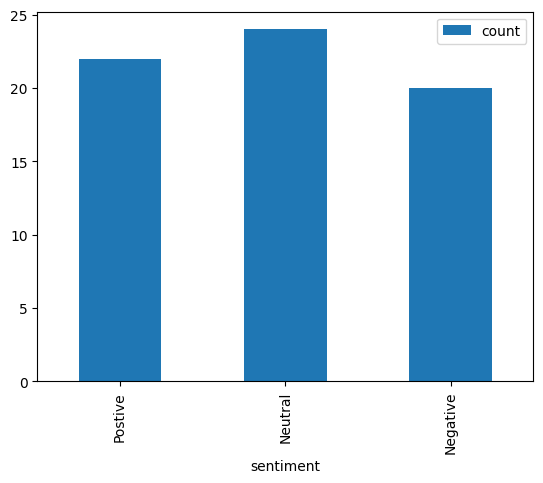

22/10/16 16:00:13 WARN KafkaDataConsumer: KafkaDataConsumer is not running in UninterruptibleThread. It may hang when KafkaDataConsumer's methods are interrupted because of KAFKA-1894


In [58]:
# Plot as a bar graph the various sentiment values
final_result.plot.bar('sentiment', 'count')